In [1]:
import os
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%cd ..

/home/luana/Bureau/fairness


## Verification du biais

In [3]:
from bin.data_loaders import DataLoader
from bin.data_trainers import DataTrainer

loader = DataLoader()

trainer = DataTrainer(loader)

In [4]:
trainer.set_logistic_regression()
trainer.train_state('TX')

y_pred = trainer.test_model()
y_pred

array([ True, False, False, ..., False, False, False])

In [5]:
df_test = loader.X_test.copy()
df_test['prediction'] = y_pred
df_man = df_test[df_test['SEX'] == 1]
df_woman = df_test[df_test['SEX'] == 2]

In [6]:
df_man_true = df_man[df_man['prediction'] == True]
df_man_false = df_man[df_man['prediction'] == False]
print(df_man_true['prediction'].count())
print(df_man_false['prediction'].count())

3162
4143


In [7]:
df_woman_true = df_woman[df_woman['prediction'] == True]
df_woman_false = df_woman[df_woman['prediction'] == False]
print(df_woman_true['prediction'].count())
print(df_woman_false['prediction'].count())

1272
5016


### On vérifie la difference entre prediction d'hommes et femmes qui reçoivent > 50000

In [8]:
df_woman_true['prediction'].count()/df_man_true['prediction'].count()

0.40227703984819735

In [9]:
df_woman_false['prediction'].count()/df_man_false['prediction'].count()

1.2107168718320058

## Analysis des Anchors

### PCA et les Anchors

In [10]:
file_path = 'xai/output/json/skrub_tx_anchors_explanations.json'

with open(file_path, 'r', encoding='utf-8') as f:
    dados = json.load(f)

test_ids = [int(id) for id in dados.keys()]

In [11]:
data_tx, _, _ = loader.get_data_state('TX')

train_data_tx = data_tx[~data_tx.index.isin(test_ids)]

test_data_tx = data_tx.loc[test_ids]

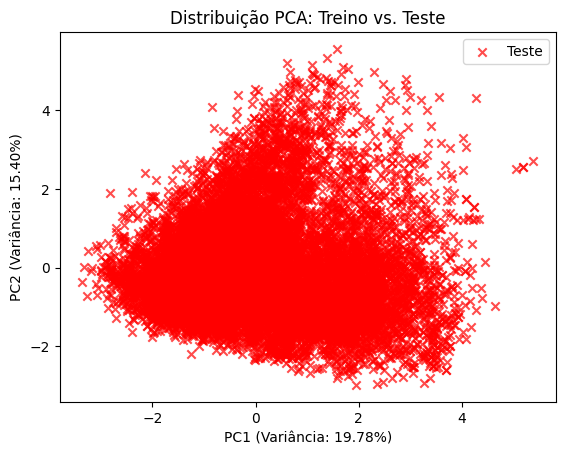

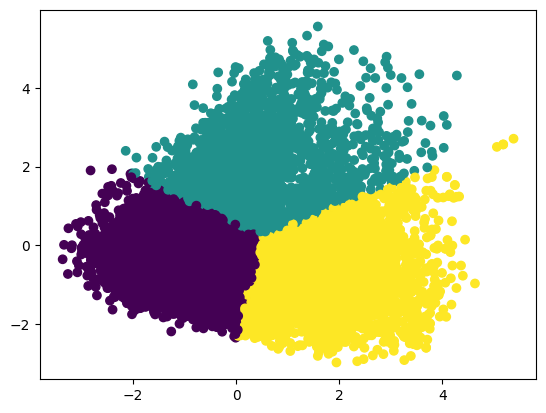

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_data_tx)
X_test_scaled = scaler.transform(test_data_tx)

pca = PCA(n_components=2)  # Para 3D, use n_components=3
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5, label='Treino', c='blue')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], alpha=0.7, label='Teste', c='red', marker='x')
plt.xlabel('PC1 (Variância: {:.2f}%)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (Variância: {:.2f}%)'.format(pca.explained_variance_ratio_[1]*100))
plt.legend()
plt.title('Distribuição PCA: Treino vs. Teste')
plt.show()

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X_test_pca)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=clusters, cmap='viridis')
plt.show()

In [27]:
test_data_tx

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P
68883,52.0,6.0,19.0,1.0,7640.0,48.0,0.0,2.0,1.0,1.0
2349,29.0,1.0,14.0,5.0,9720.0,48.0,16.0,45.0,1.0,9.0
109543,55.0,1.0,1.0,1.0,4521.0,247.0,6.0,60.0,2.0,6.0
76730,38.0,1.0,17.0,5.0,5110.0,48.0,12.0,40.0,2.0,1.0
123558,60.0,1.0,16.0,1.0,6200.0,5.0,0.0,50.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
13904,63.0,1.0,19.0,1.0,600.0,48.0,0.0,40.0,1.0,1.0
52006,56.0,3.0,19.0,1.0,3710.0,48.0,1.0,55.0,1.0,1.0
22372,65.0,4.0,22.0,1.0,230.0,128.0,0.0,42.0,2.0,1.0
86267,26.0,1.0,13.0,5.0,5400.0,6.0,2.0,25.0,2.0,1.0


In [26]:
for i in range(2):
    print(f"PCA {i+1}")
    for c, v in zip(test_data_tx.columns, pca.components_[i]):
        print(f"{c}: {v}")

    print('\n')

PCA 1
AGEP: -0.4795470209870698
COW: -0.24283420157734315
SCHL: -0.29355329452113843
MAR: 0.5166226005548015
OCCP: 0.30998974072921637
POBP: 0.10269698943453424
RELP: 0.44549135536278806
WKHP: -0.1716358648483151
SEX: -0.028407058375707634
RAC1P: 0.15041631331558877


PCA 2
AGEP: 0.24489790464326036
COW: 0.00848334718777835
SCHL: -0.49040001239091774
MAR: -0.28736497174895687
OCCP: 0.3855687531201277
POBP: 0.5067400855405317
RELP: -0.14925177411216692
WKHP: 0.16923487898584427
SEX: -0.30341061090934673
RAC1P: 0.2616465882654329




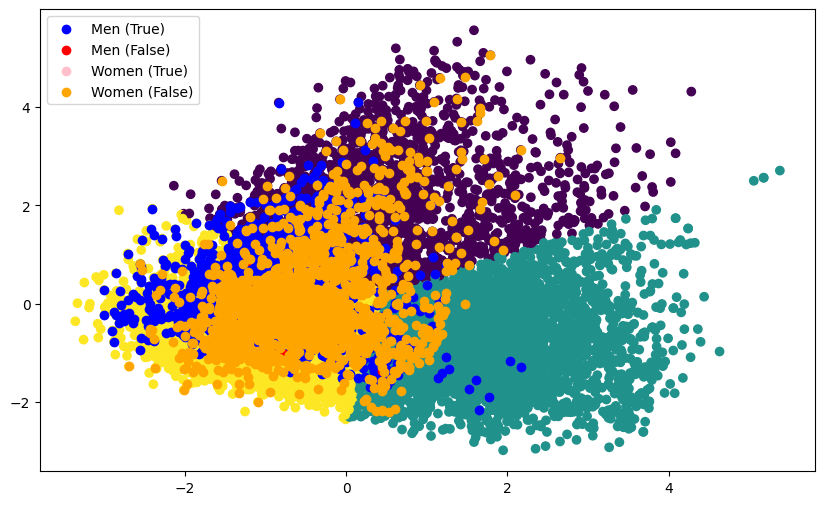

In [119]:
sex_anchors_true, anchors_ids_true = analyse_sex_anchors(dados, ['prediction', 'precision'], ['True', 0.95])
sex_anchors_false, anchors_ids_false = analyse_sex_anchors(dados, ['prediction', 'precision'], ['False', 0.95])

anchors_ids_true = [int(id) for id in anchors_ids_true]
anchors_ids_false = [int(id) for id in anchors_ids_false]

man_indices = test_data_tx.index[test_data_tx['SEX'].isin([1])].tolist()
woman_indices = test_data_tx.index[test_data_tx['SEX'].isin([2])].tolist()

mask_male_true = test_data_tx.index.isin(anchors_ids_true) & test_data_tx.index.isin(man_indices)
mask_male_false = test_data_tx.index.isin(anchors_ids_false) & test_data_tx.index.isin(man_indices)
mask_female_true = test_data_tx.index.isin(anchors_ids_true) & test_data_tx.index.isin(woman_indices)
mask_female_false = test_data_tx.index.isin(anchors_ids_false) & test_data_tx.index.isin(woman_indices)

plt.figure(figsize=(10, 6))

# Plotar pontos
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=clusters, cmap='viridis')
plt.scatter(X_test_pca[mask_male_true, 0], X_test_pca[mask_male_true, 1], c='blue', label='Men (True)')
plt.scatter(X_test_pca[mask_male_false, 0], X_test_pca[mask_male_false, 1], c='red', label='Men (False)')
plt.scatter(X_test_pca[mask_female_true, 0], X_test_pca[mask_female_true, 1], c='pink', label='Women (True)')
plt.scatter(X_test_pca[mask_female_false, 0], X_test_pca[mask_female_false, 1], c='orange', label='Women (False)')

plt.legend()
plt.show()

### Distribuitions des Anchors

In [62]:
def plot_sex_anchors_comparison(ax, true_pred, false_pred, title_suffix=""):
    # Map anchor's labels
    labels_map = {
        'SEX <= 1.00': 'Male (SEX=1)',
        'SEX > 1.00': 'Female (SEX>1)',
        'SEX <= 2.00': 'Female (SEX=2)'
    }
    
    # Process data
    categories = ['Male (SEX=1)', 'Female (SEX>1)', 'Both (SEX<=2)']
    true_counts = [true_pred.get('SEX <= 1.00', 0), 
                   true_pred.get('SEX > 1.00', 0), 
                   true_pred.get('SEX <= 2.00', 0)]
    false_counts = [false_pred.get('SEX <= 1.00', 0), 
                    false_pred.get('SEX > 1.00', 0), 
                    false_pred.get('SEX <= 2.00', 0)]
    
    # Configure graphic
    x = np.arange(len(categories))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(8, 4))
    rects1 = ax.bar(x - width/2, true_counts, width, label='True Predictions', color='#ff7f0e')
    rects2 = ax.bar(x + width/2, false_counts, width, label='False Predictions', color='#1f77b4')
    
    # Adiciona texto e formatação
    ax.set_ylabel('Anchors count')
    ax.set_title(f"Distribution of Anchors by SEX feature: {title_suffix}")
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Adiciona valores nas barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)

In [63]:
def analyse_sex_anchors(data, cond = [], cond_value = []):
    if len(cond) != len(cond_value):
        raise ValueError("As listas 'cond' e 'cond_value' devem ter o mesmo tamanho")
        
    sex_anchors = dict()
    sex_anchors_ids = []
    for key, value in data.items():
        all_cond = True
        if len(cond) != 0:
            for c, v in zip(cond, cond_value):
                if c == 'precision':
                    condition = value.get('precision') > v
                elif c == 'prediction':
                    condition = value.get('prediction') == v
                elif c == 'coverage':
                    condition = value.get('coverage') > v
                elif c == 'num_features':
                    condition = len(value.get('features')) <= v
                else:
                    condition = True
                all_cond = all_cond and condition
        
        if all_cond:
            for f in value.get('features'):
                if f.get('feature_name') == 'SEX':
                    feature_range = f.get('feature_ranges')
                        
                    if feature_range not in sex_anchors:
                        sex_anchors[feature_range] = 0
                    
                    sex_anchors[feature_range] += 1
                    sex_anchors_ids.append(key)

    return sex_anchors, sex_anchors_ids

In [64]:
# HOMME - 1
# FEMME - 2

def analyse_anchors(file_path, bool_label = 'str'):
    with open(file_path, 'r', encoding='utf-8') as f:
        dados = json.load(f)
    
    print("Total of test data: ", len(dados.items()))
    
    sex = {
        'femme': 0,
        'homme': 0
    }
    
    for chave, valor in dados.items():        
        for f in valor.get('features'):
            if f.get('feature_name') == 'SEX':
                if f.get('feature_value') == 1:
                    sex['homme'] += 1
                else:
                    sex['femme'] += 1

    print("Total of anchors of men: ", sex['homme'])
    print("Total of anchors of women: ", sex['femme'])

    if bool_label == 'str':
        true_label = "True"
        false_label = "False"
    else:
        true_label = 1
        false_label = 0
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle("Anchors Analysis by SEX Feature", fontsize=16)
    axs = axs.ravel()  # Flatten the array of axes
    
    # Plot 1: Basic prediction comparison
    true, _ = analyse_sex_anchors(dados, ['prediction'], [true_label])
    false, _ = analyse_sex_anchors(dados, ['prediction'], [false_label])
    print(f"For true predictions: {true} \nFor false predictions: {false}")
    plot_sex_anchors_comparison(axs[0], true, false, "Prediction = 'True'/'False'")
    
    # Plot 2: Prediction with coverage
    true, _ = analyse_sex_anchors(dados, ['prediction', 'coverage'], [true_label, 0.2])
    false, _ = analyse_sex_anchors(dados, ['prediction', 'coverage'], [false_label, 0.2])
    print(f"For true predictions and coverage > 0.2: {true} \nFor false predictions and coverage > 0.2: {false}")
    plot_sex_anchors_comparison(axs[1], true, false, "Prediction = 'True'/'False'\nCoverage > 0.2")
    
    # Plot 3: Prediction with precision
    true, _ = analyse_sex_anchors(dados, ['prediction', 'precision'], [true_label, 0.95])
    false, _ = analyse_sex_anchors(dados, ['prediction', 'precision'], [false_label, 0.95])
    print(f"For true predictions and precision > 0.95: {true} \nFor false predictions and precision > 0.95: {false}")
    plot_sex_anchors_comparison(axs[2], true, false, "Prediction = 'True'/'False'\nPrecision > 0.95")
    
    # Plot 4: Prediction with num_features
    true, _ = analyse_sex_anchors(dados, ['prediction', 'num_features'], [true_label, 3])
    false, _ = analyse_sex_anchors(dados, ['prediction', 'num_features'], [false_label, 3])
    print(f"For true predictions and num_features <= 3: {true} \nFor false predictions and num_features <= 3: {false}")
    plot_sex_anchors_comparison(axs[3], true, false, "Prediction = 'True'/'False'\nNum_features <= 3")
    
    # Plot 5: Prediction with precision and coverage
    true, _ = analyse_sex_anchors(dados, ['prediction', 'precision', 'coverage'], [true_label, 0.95, 0.2])
    false, _ = analyse_sex_anchors(dados, ['prediction', 'precision', 'coverage'], [false_label, 0.95, 0.2])
    print(f"For true predictions and precision > 0.95 and coverage > 0.2: {true} \nFor false predictions and precision > 0.95 and coverage > 0.2: {false}")
    plot_sex_anchors_comparison(axs[4], true, false, "Prediction = 'True'/'False'\nPrecision > 0.95; Coverage > 0.2")
    
    # Hide the last subplot if we have an odd number of plots
    if len(axs) > 5:
        axs[5].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

Total of test data:  13593
Total of anchors of men:  1921
Total of anchors of women:  1795
For true predictions: {'SEX <= 1.00': 1904, 'SEX <= 2.00': 159} 
For false predictions: {'SEX > 1.00': 1625, 'SEX <= 2.00': 13, '1.00 < SEX <= 2.00': 11, 'SEX <= 1.00': 4}
For true predictions and coverage > 0.2: {} 
For false predictions and coverage > 0.2: {'SEX > 1.00': 225, 'SEX <= 2.00': 5}
For true predictions and precision > 0.95: {'SEX <= 1.00': 1670, 'SEX <= 2.00': 4} 
For false predictions and precision > 0.95: {'SEX > 1.00': 1614, 'SEX <= 1.00': 1, '1.00 < SEX <= 2.00': 3, 'SEX <= 2.00': 2}
For true predictions and num_features <= 3: {} 
For false predictions and num_features <= 3: {'SEX > 1.00': 1479}
For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {'SEX > 1.00': 225}


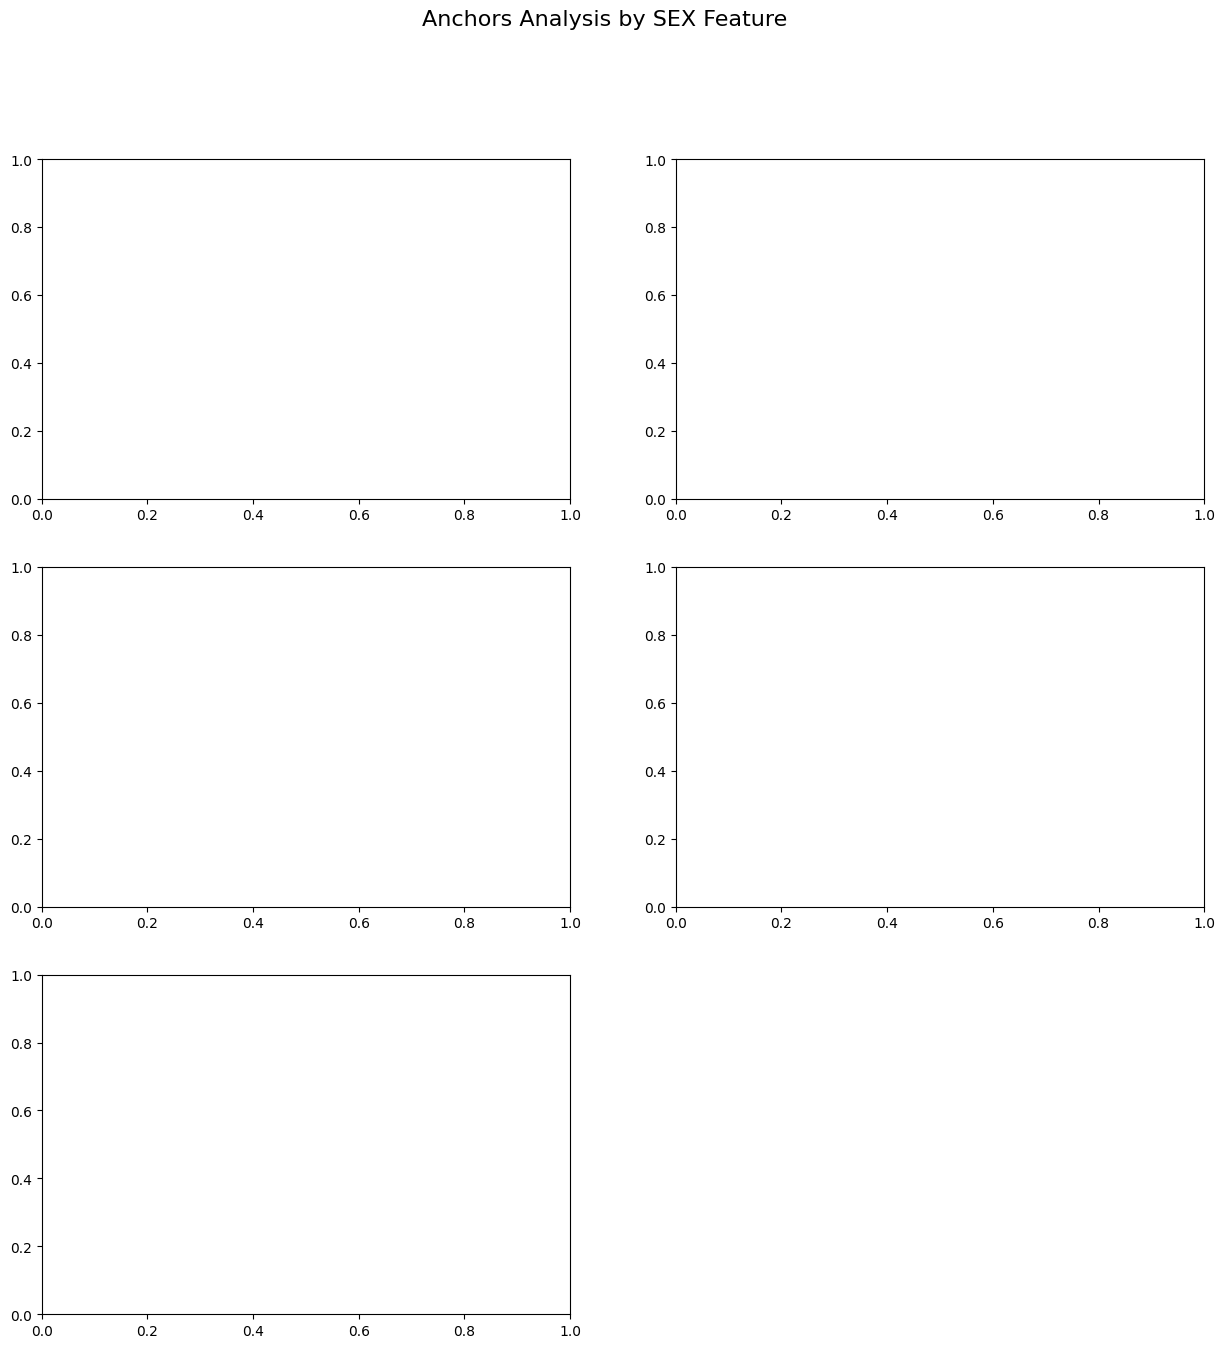

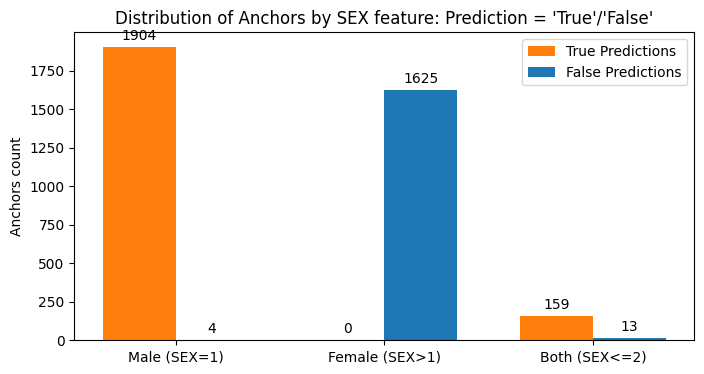

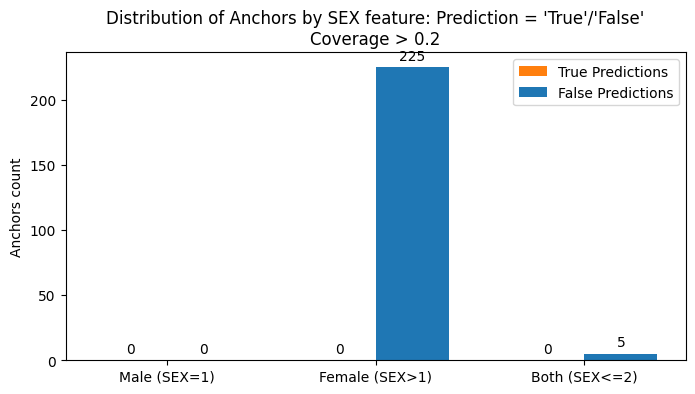

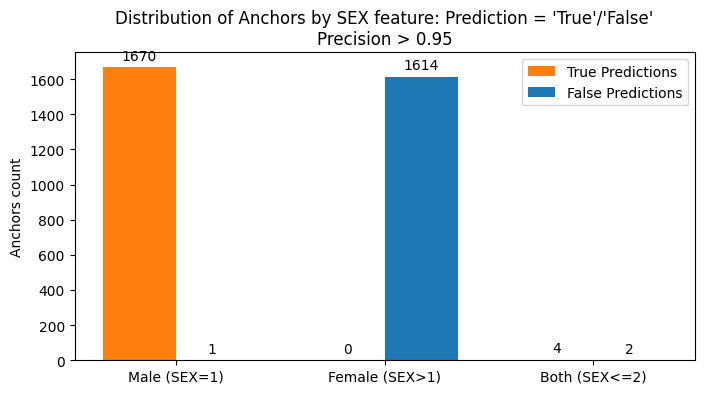

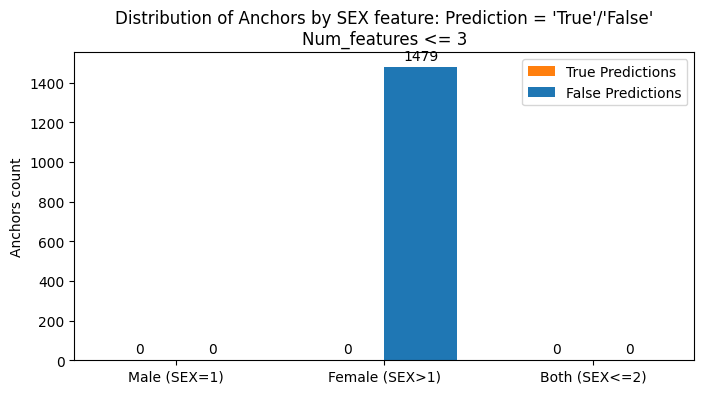

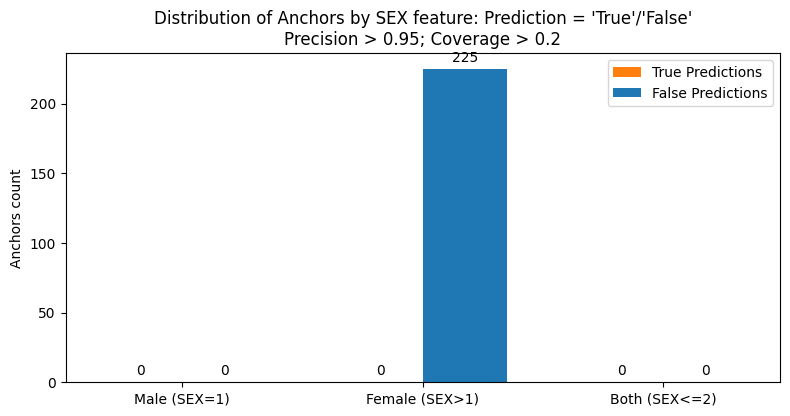

In [65]:
file = 'xai/output/json/skrub_tx_anchors_explanations.json'
analyse_anchors(file)

Total of test data:  13593
Total of anchors of men:  2261
Total of anchors of women:  1892
For true predictions: {'SEX <= 1.00': 2173, 'SEX <= 2.00': 272} 
For false predictions: {'SEX > 1.00': 1593, '1.00 < SEX <= 2.00': 25, 'SEX <= 2.00': 85, 'SEX <= 1.00': 5}
For true predictions and coverage > 0.2: {'SEX <= 1.00': 1} 
For false predictions and coverage > 0.2: {'SEX > 1.00': 113, 'SEX <= 2.00': 3}
For true predictions and precision > 0.95: {'SEX <= 1.00': 1546, 'SEX <= 2.00': 9} 
For false predictions and precision > 0.95: {'SEX > 1.00': 1564, 'SEX <= 2.00': 17, '1.00 < SEX <= 2.00': 5, 'SEX <= 1.00': 3}
For true predictions and num_features <= 3: {'SEX <= 1.00': 8} 
For false predictions and num_features <= 3: {'SEX > 1.00': 1280, 'SEX <= 1.00': 1}
For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {'SEX > 1.00': 110}


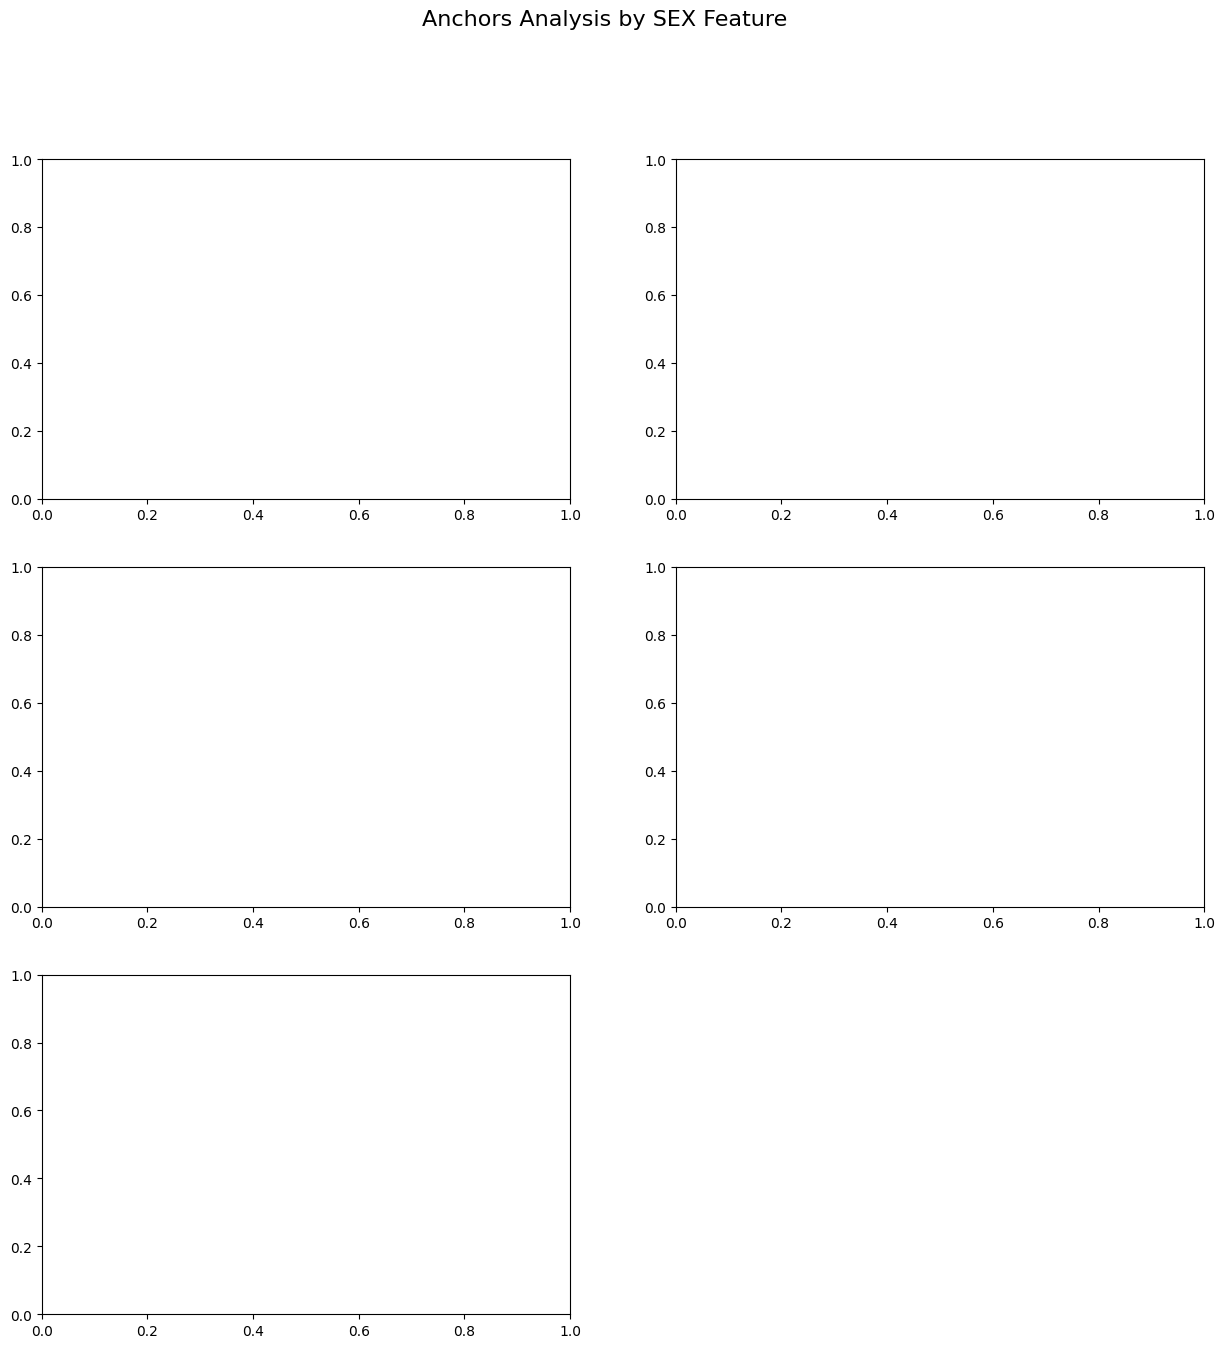

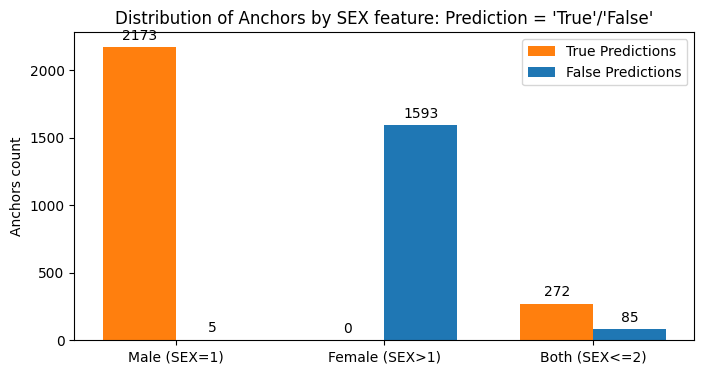

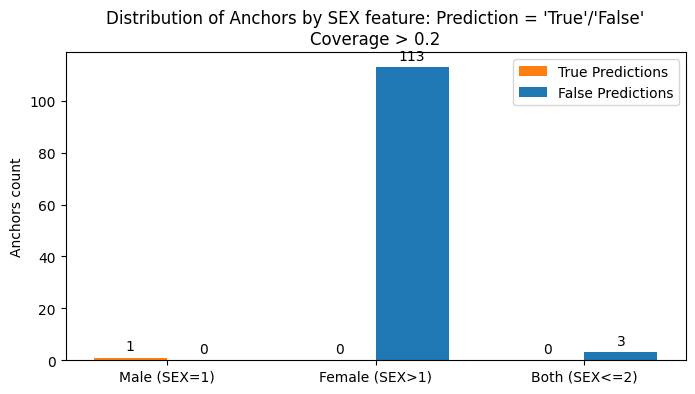

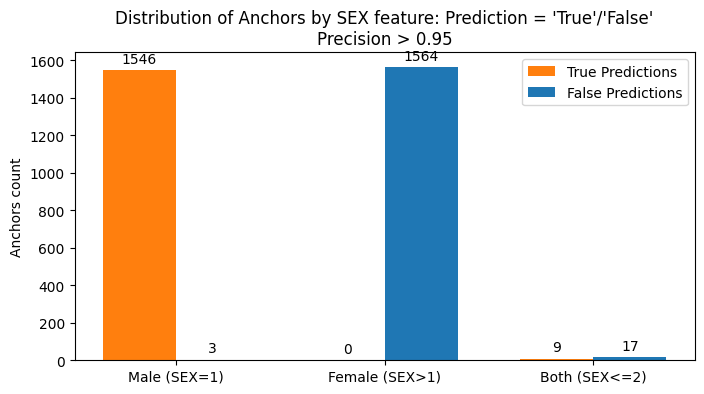

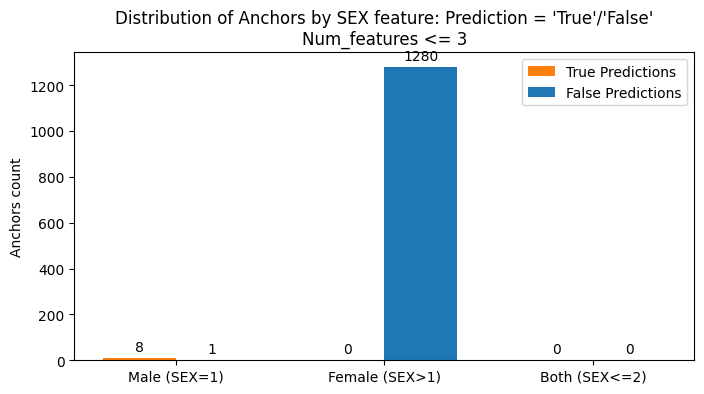

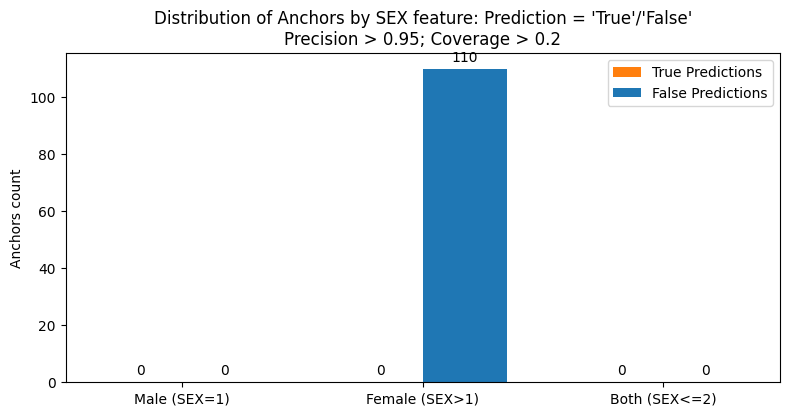

In [66]:
file = 'xai/output/json/xg_tx_anchors_explanations.json'
analyse_anchors(file, 'num')

Total of test data:  19567
Total of anchors of men:  1876
Total of anchors of women:  1273
For true predictions: {'SEX <= 1.00': 1827, 'SEX <= 2.00': 228} 
For false predictions: {'SEX > 1.00': 991, '1.00 < SEX <= 2.00': 52, 'SEX <= 2.00': 44, 'SEX <= 1.00': 7}
For true predictions and coverage > 0.2: {} 
For false predictions and coverage > 0.2: {'SEX > 1.00': 1, 'SEX <= 2.00': 2}
For true predictions and precision > 0.95: {'SEX <= 1.00': 1584, 'SEX <= 2.00': 13} 
For false predictions and precision > 0.95: {'SEX > 1.00': 952, 'SEX <= 2.00': 5, '1.00 < SEX <= 2.00': 9, 'SEX <= 1.00': 4}
For true predictions and num_features <= 3: {'SEX <= 1.00': 6} 
For false predictions and num_features <= 3: {'SEX > 1.00': 534, '1.00 < SEX <= 2.00': 1, 'SEX <= 2.00': 1}
For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {}


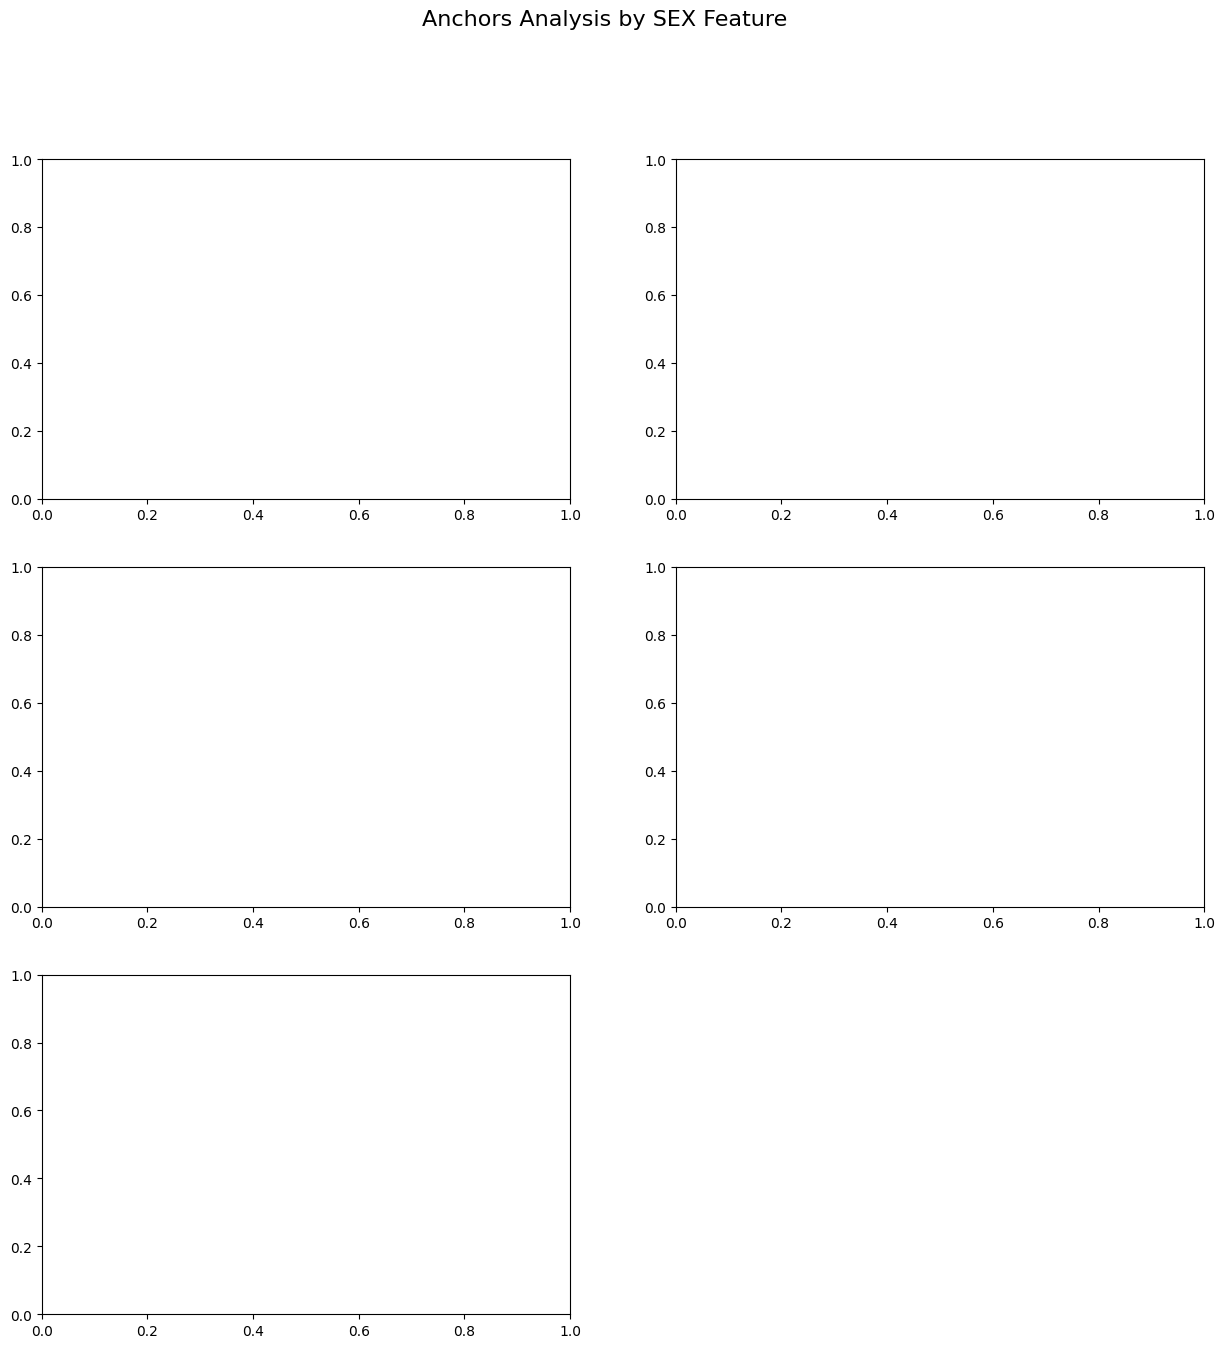

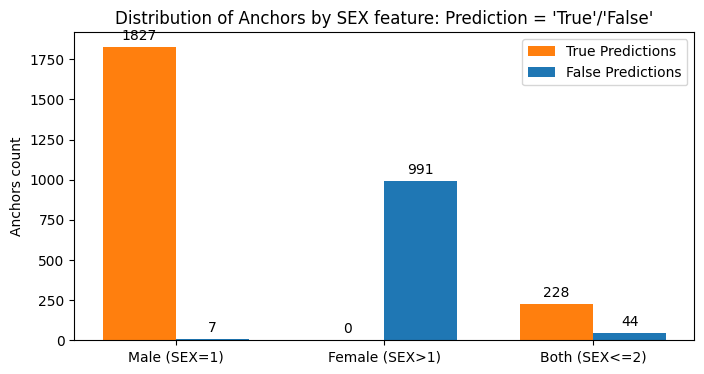

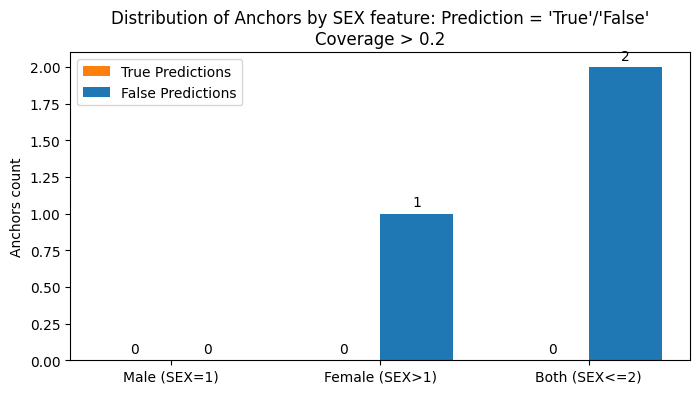

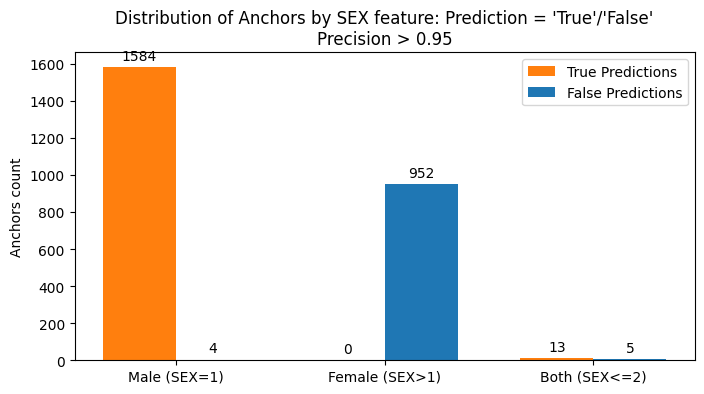

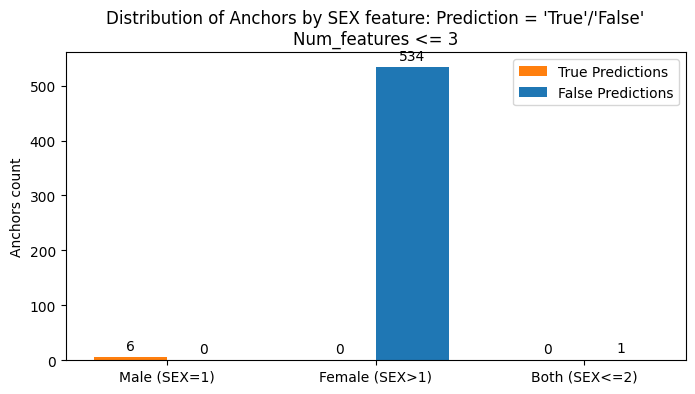

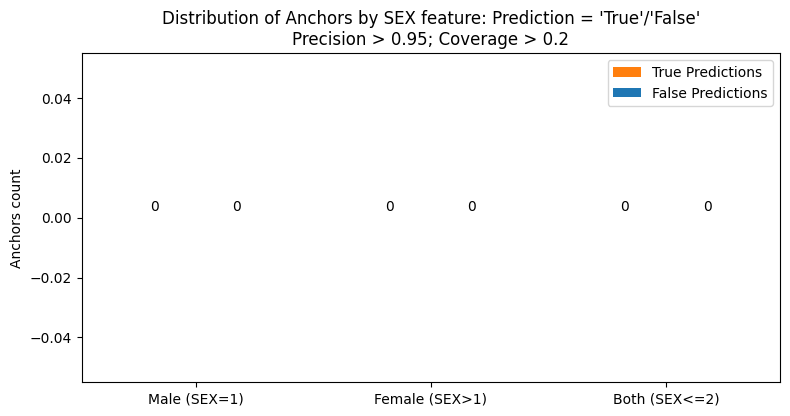

In [67]:
file = 'xai/output/json/skrub_ca_anchors_explanations.json'
analyse_anchors(file)

Total of test data:  19567
Total of anchors of men:  2466
Total of anchors of women:  1497
For true predictions: {'SEX <= 2.00': 351, 'SEX <= 1.00': 2353} 
For false predictions: {'SEX > 1.00': 1026, '1.00 < SEX <= 2.00': 103, 'SEX <= 2.00': 114, 'SEX <= 1.00': 16}
For true predictions and coverage > 0.2: {'SEX <= 2.00': 1, 'SEX <= 1.00': 1} 
For false predictions and coverage > 0.2: {'SEX <= 2.00': 10, 'SEX > 1.00': 2}
For true predictions and precision > 0.95: {'SEX <= 1.00': 1733, 'SEX <= 2.00': 9} 
For false predictions and precision > 0.95: {'SEX > 1.00': 938, '1.00 < SEX <= 2.00': 20, 'SEX <= 1.00': 10, 'SEX <= 2.00': 17}
For true predictions and num_features <= 3: {'SEX <= 1.00': 31, 'SEX <= 2.00': 1} 
For false predictions and num_features <= 3: {'SEX > 1.00': 291}
For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {}


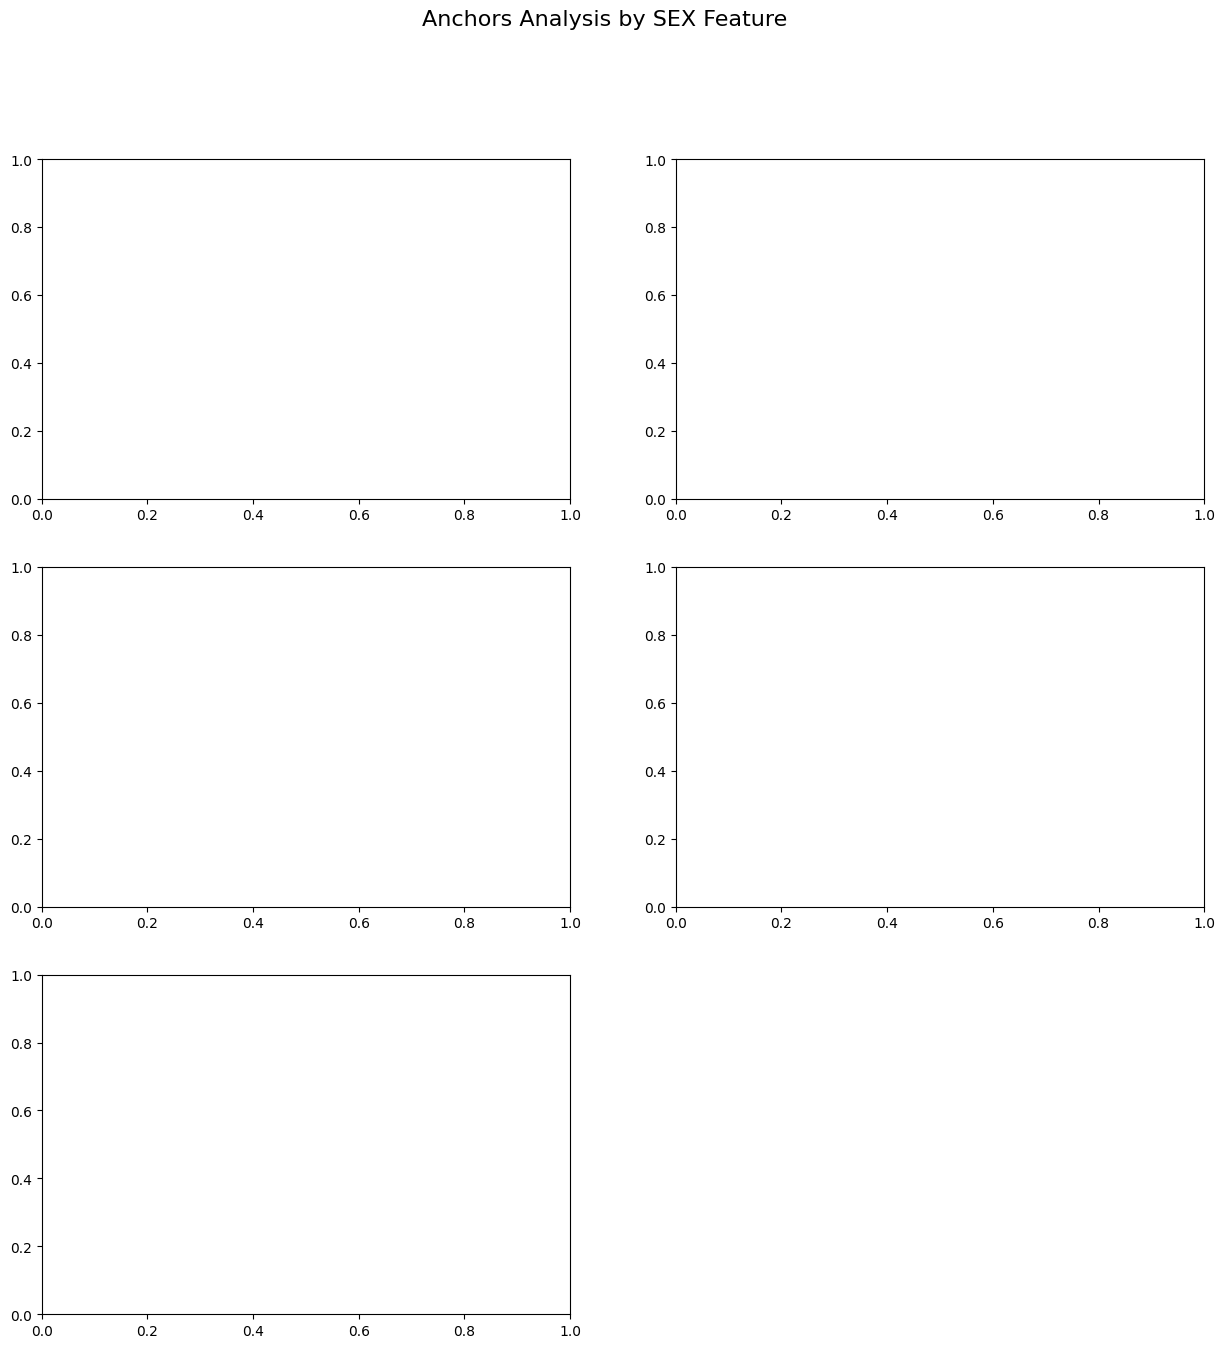

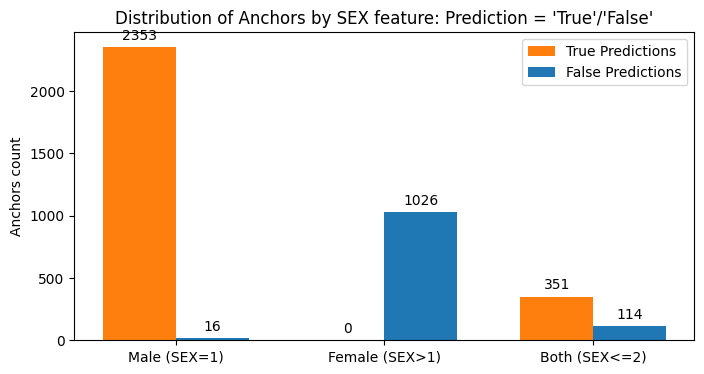

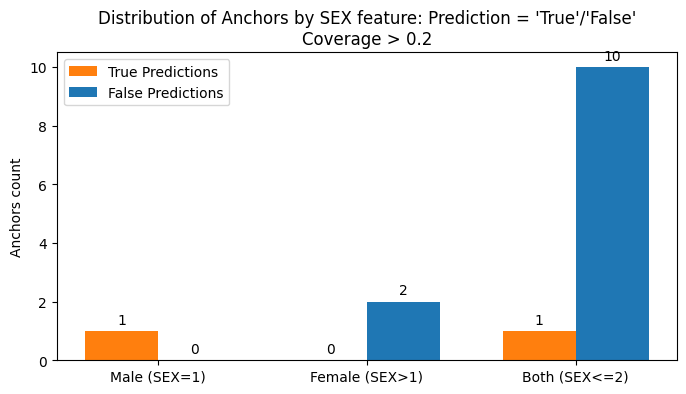

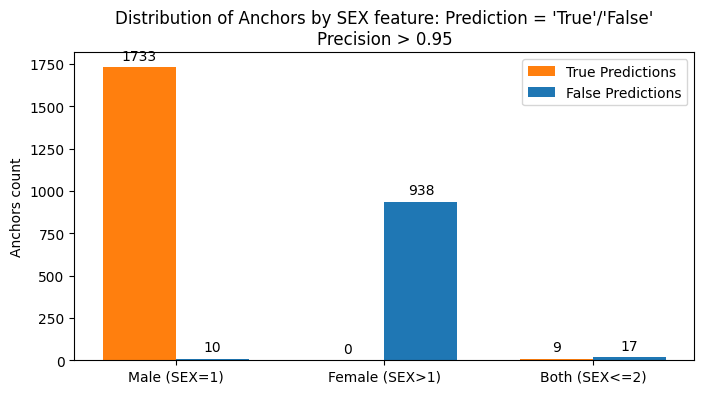

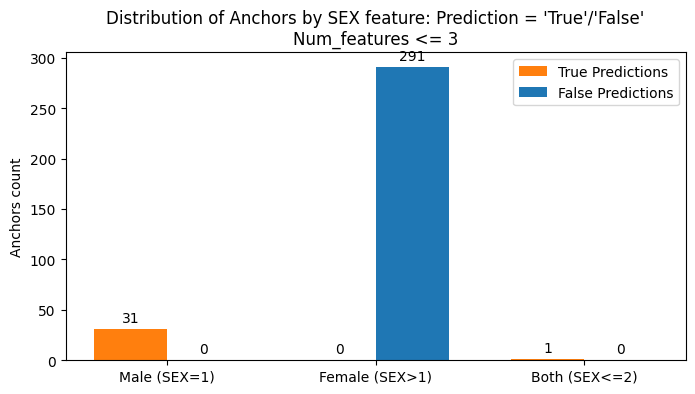

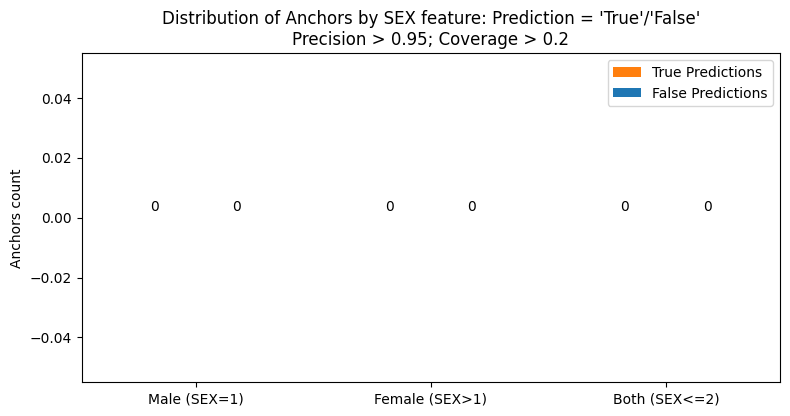

In [68]:
file = 'xai/output/json/xg_ca_anchors_explanations.json'
analyse_anchors(file, 'num')

Total of test data:  10303
Total of anchors of men:  1188
Total of anchors of women:  943
For true predictions: {'SEX <= 1.00': 1134, 'SEX <= 2.00': 199} 
For false predictions: {'SEX <= 2.00': 48, 'SEX > 1.00': 699, '1.00 < SEX <= 2.00': 43, 'SEX <= 1.00': 8}
For true predictions and coverage > 0.2: {'SEX <= 2.00': 1} 
For false predictions and coverage > 0.2: {'SEX <= 2.00': 6, 'SEX > 1.00': 2}
For true predictions and precision > 0.95: {'SEX <= 1.00': 787, 'SEX <= 2.00': 5} 
For false predictions and precision > 0.95: {'SEX > 1.00': 674, '1.00 < SEX <= 2.00': 11, 'SEX <= 2.00': 8, 'SEX <= 1.00': 6}
For true predictions and num_features <= 3: {'SEX <= 1.00': 3} 
For false predictions and num_features <= 3: {'SEX > 1.00': 402, 'SEX <= 1.00': 1, 'SEX <= 2.00': 1}
For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {'SEX > 1.00': 2}


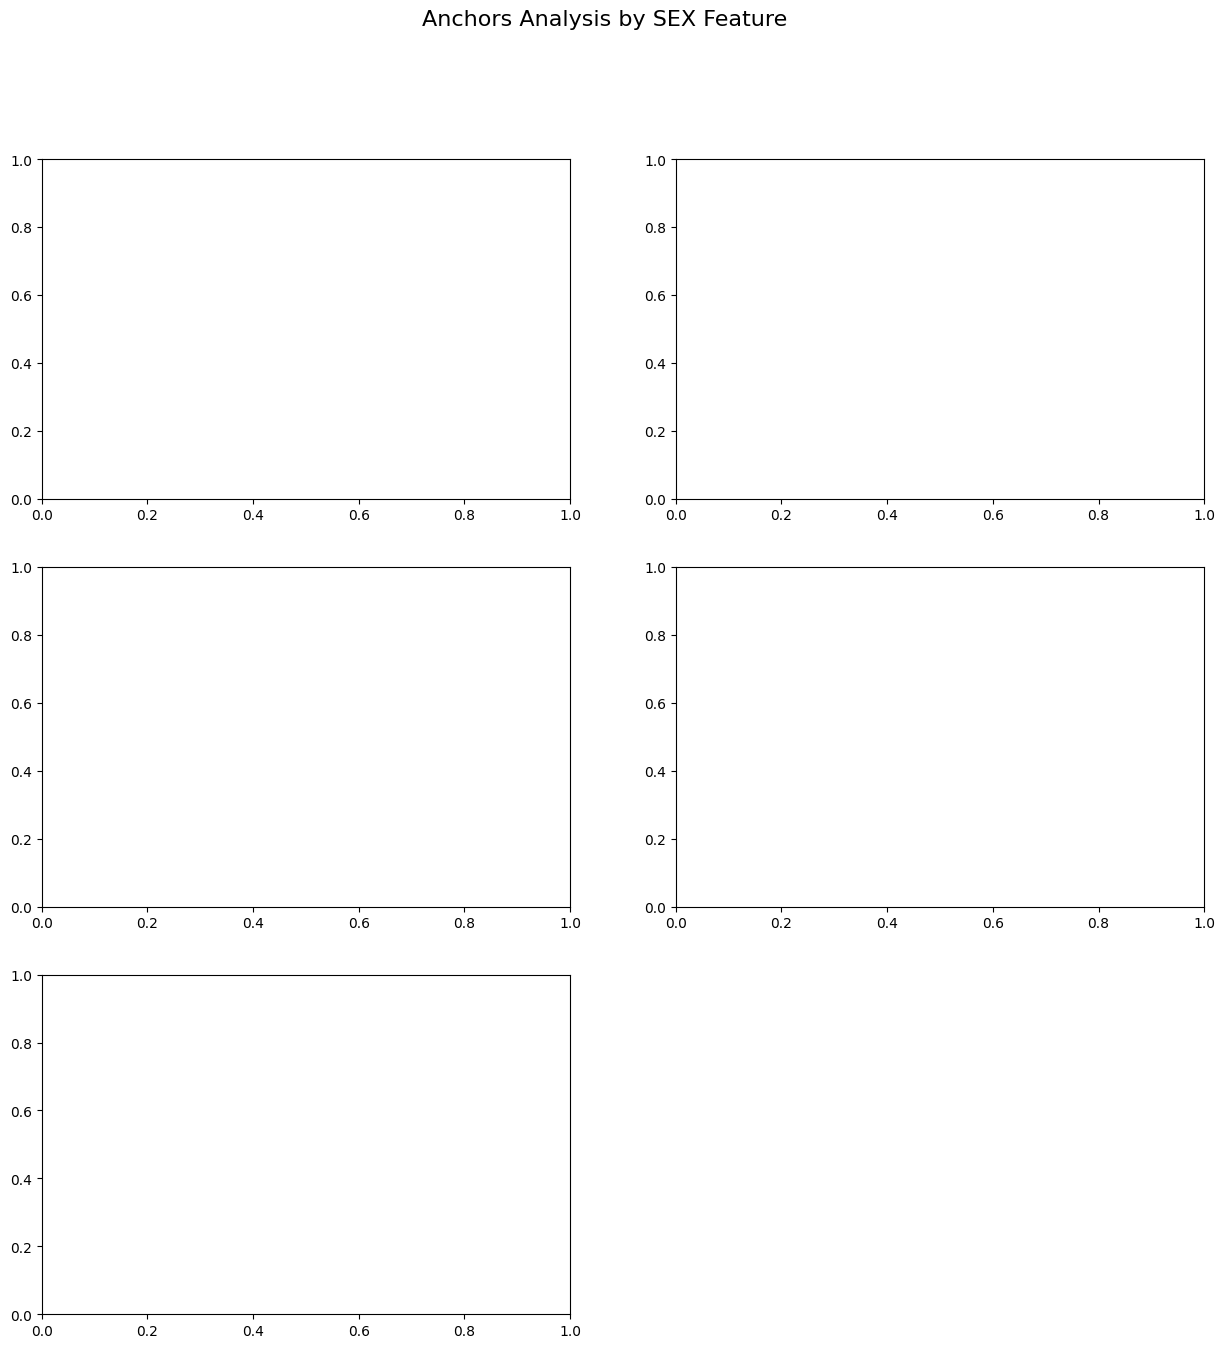

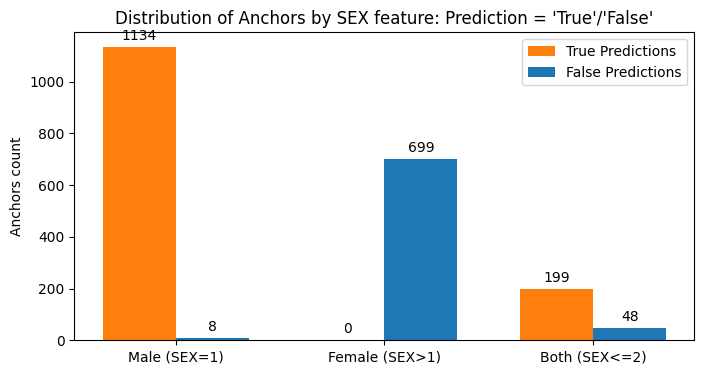

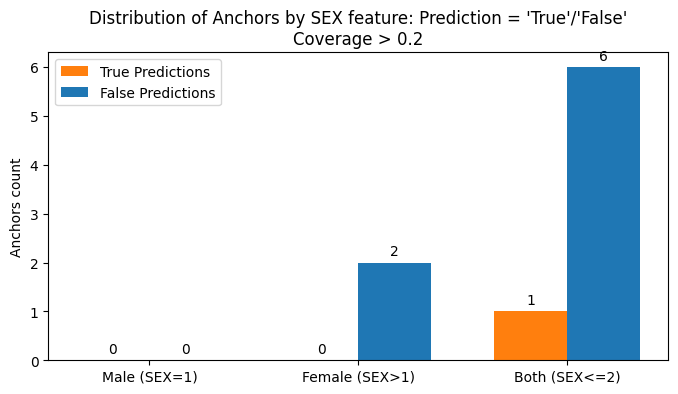

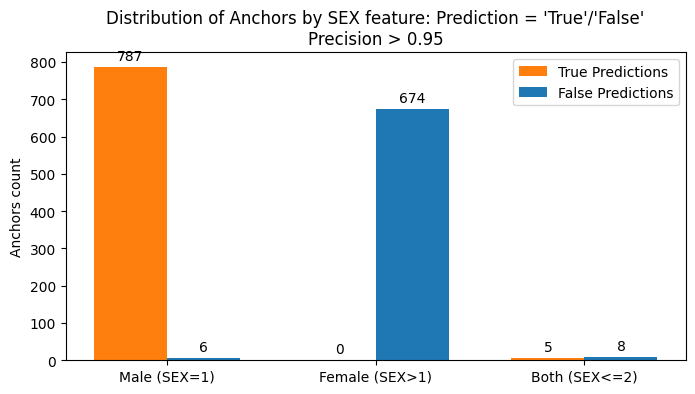

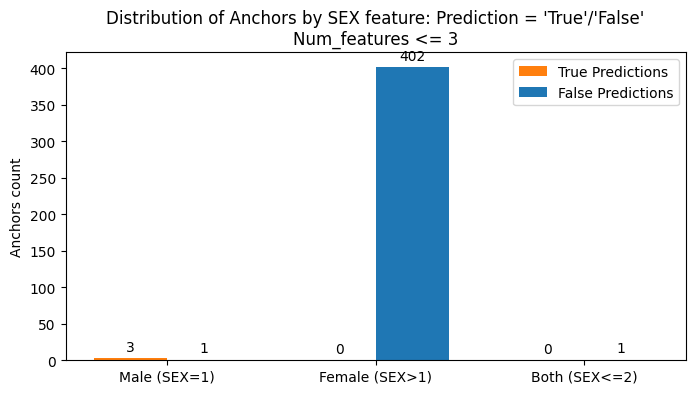

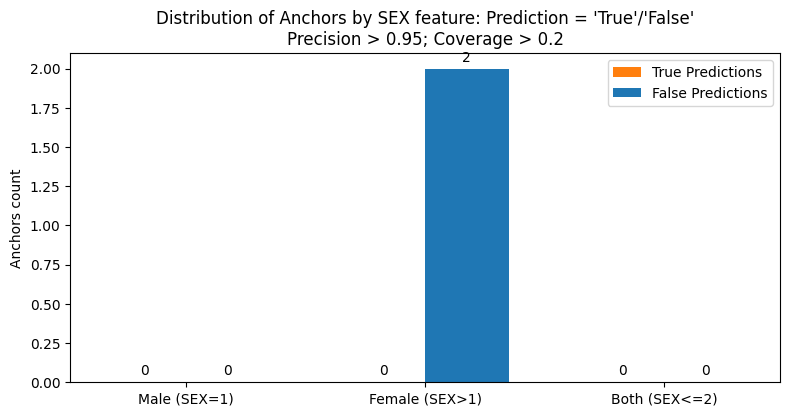

In [69]:
file = 'xai/output/json/skrub_ny_anchors_explanations.json'
analyse_anchors(file)

Total of test data:  10303
Total of anchors of men:  1457
Total of anchors of women:  1500
For true predictions: {'SEX <= 1.00': 1312, 'SEX <= 2.00': 322, '1.00 < SEX <= 2.00': 2} 
For false predictions: {'SEX > 1.00': 1083, '1.00 < SEX <= 2.00': 97, 'SEX <= 2.00': 123, 'SEX <= 1.00': 18}
For true predictions and coverage > 0.2: {'SEX <= 1.00': 1, 'SEX <= 2.00': 1} 
For false predictions and coverage > 0.2: {'SEX <= 2.00': 6}
For true predictions and precision > 0.95: {'SEX <= 1.00': 681, 'SEX <= 2.00': 12, '1.00 < SEX <= 2.00': 1} 
For false predictions and precision > 0.95: {'SEX > 1.00': 1017, '1.00 < SEX <= 2.00': 25, 'SEX <= 2.00': 15, 'SEX <= 1.00': 9}
For true predictions and num_features <= 3: {'SEX <= 1.00': 4} 
For false predictions and num_features <= 3: {'SEX > 1.00': 438, '1.00 < SEX <= 2.00': 1, 'SEX <= 2.00': 2}
For true predictions and precision > 0.95 and coverage > 0.2: {} 
For false predictions and precision > 0.95 and coverage > 0.2: {}


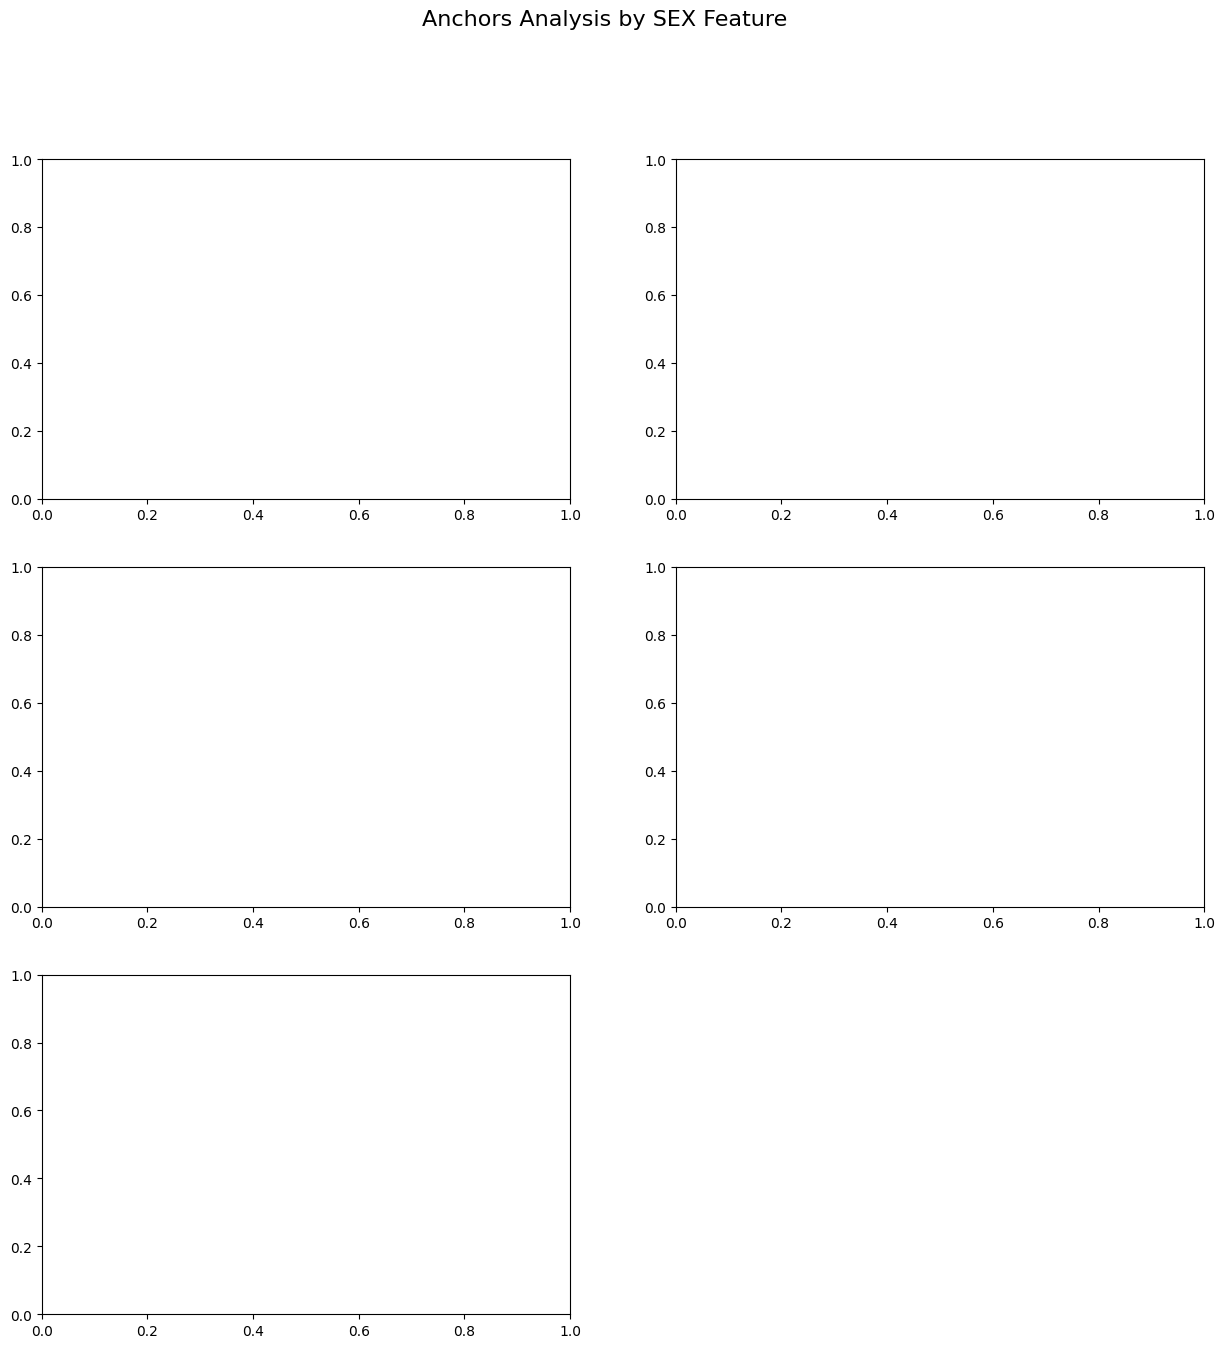

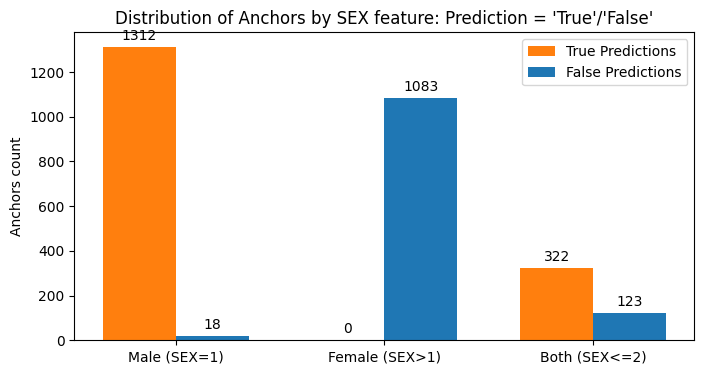

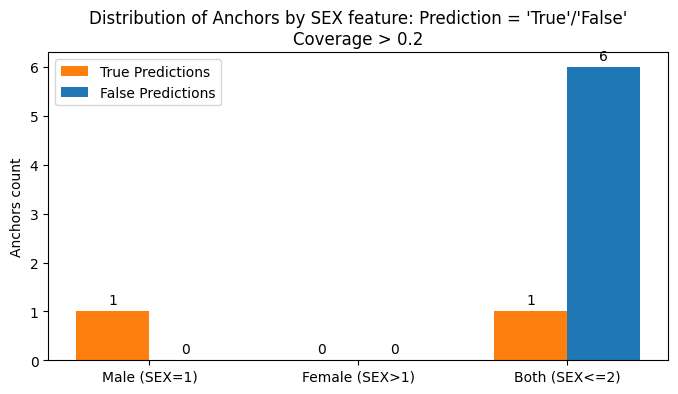

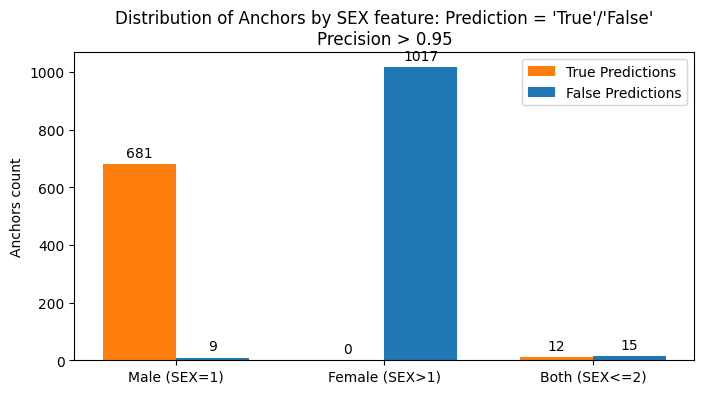

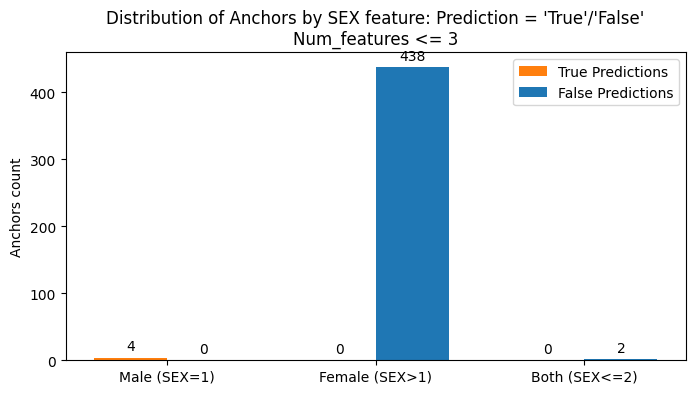

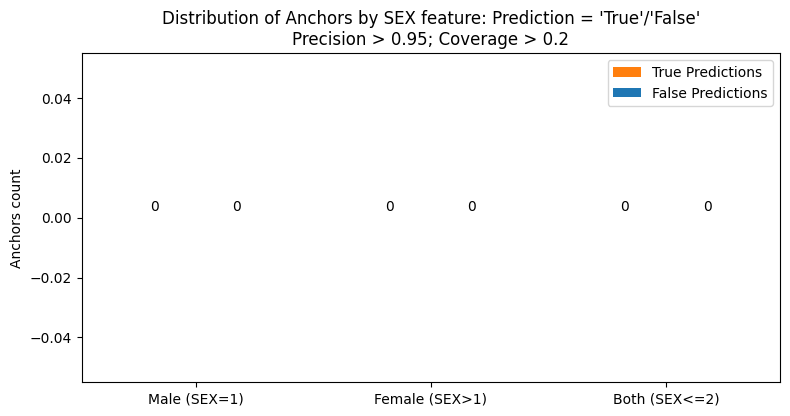

In [70]:
file = 'xai/output/json/xg_ny_anchors_explanations.json'
analyse_anchors(file, 'num')

## Analysis des explications SHAP

In [71]:
def plot_sex_shap_comparison(true_pred, false_pred, title_suffix=""):
    # Map anchor's labels
    labels_map = {
        1: 'Male (SEX=1)',
        2: 'Female (SEX>1)'
    }
    
    # Process data
    categories = ['Male (SEX=1)', 'Female (SEX=2)']
    true_counts = [true_pred.get(1, 0), 
                   true_pred.get(2, 0)]
    false_counts = [false_pred.get(1, 0), 
                    false_pred.get(2, 0)]
    
    # Configure graphic
    x = np.arange(len(categories))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(8, 4))
    rects1 = ax.bar(x - width/2, true_counts, width, label='True Predictions', color='#ff7f0e')
    rects2 = ax.bar(x + width/2, false_counts, width, label='False Predictions', color='#1f77b4')
    
    # Adiciona texto e formatação
    ax.set_ylabel('SHAP count')
    ax.set_title(f"Distribution of SHAP by SEX feature: {title_suffix}")
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Adiciona valores nas barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.show()

In [72]:
def analyse_sex_shap(dados, cond = [], cond_value = []):
    if len(cond) != len(cond_value):
        raise ValueError("As listas 'cond' e 'cond_value' devem ter o mesmo tamanho")
        
    sex_shap = dict()
    for chave, valor in dados.items():
        all_cond = True
        if len(cond) != 0:
            for c, v in zip(cond, cond_value):
                if c == 'precision':
                    condition = valor.get('precision') > v
                elif c == 'prediction':
                    condition = valor.get('prediction') == v
                elif c == 'num_features':
                    condition = len(valor.get('features')) <= v
                else:
                    condition = True
                all_cond = all_cond and condition
        
        if all_cond:
            for f in valor.get('features'):
                if f.get('feature_name') == 'SEX':
                    feature_value = f.get('feature_value')
                        
                    if feature_value not in sex_shap:
                        sex_shap[feature_value] = 0
                    
                    sex_shap[feature_value] += 1

    return sex_shap

In [73]:
# HOMME - 1
# FEMME - 2

def analyse_shap(file_path, bool_label = 'str'):
    with open(file_path, 'r', encoding='utf-8') as f:
        dados = json.load(f)
    
    print("Total of test data: ", len(dados.items()))
    
    sex = {
        'femme': 0,
        'homme': 0
    }
    
    for chave, valor in dados.items():        
        for f in valor.get('features'):
            if f.get('feature_name') == 'SEX':
                if f.get('feature_value') == 1:
                    sex['homme'] += 1
                else:
                    sex['femme'] += 1

    print("Total of shap of men: ", sex['homme'])
    print("Total of shap of women: ", sex['femme'])

    if bool_label == 'str':
        true_label = "True"
        false_label = "False"
    else:
        true_label = 1
        false_label = 0
    
    true = analyse_sex_shap(dados, ['prediction'], [true_label])
    false = analyse_sex_shap(dados, ['prediction'], [false_label])
    print(f"For true predictions: {true} \nFor false predictions: {false}")
    plot_sex_shap_comparison(true, false, "prediction = 'True'/'False'")
    
    true = analyse_sex_shap(dados, ['prediction', 'precision'], [true_label, 0.95])
    false = analyse_sex_shap(dados, ['prediction', 'precision'], [false_label, 0.95])
    print(f"For true predictions and precision > 0.95: {true} \nFor false predictions and precision > 0.95: {false}")
    plot_sex_shap_comparison(true, false, "prediction = 'True'/'False'; precision > 0.95")

Total of test data:  13593
Total of shap of men:  3221
Total of shap of women:  4755
For true predictions: {1: 3219} 
For false predictions: {2: 4755, 1: 2}


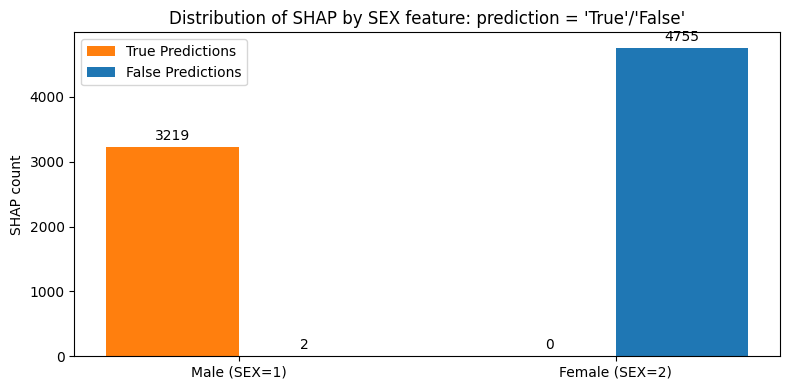

For true predictions and precision > 0.95: {1: 139} 
For false predictions and precision > 0.95: {2: 1856, 1: 2}


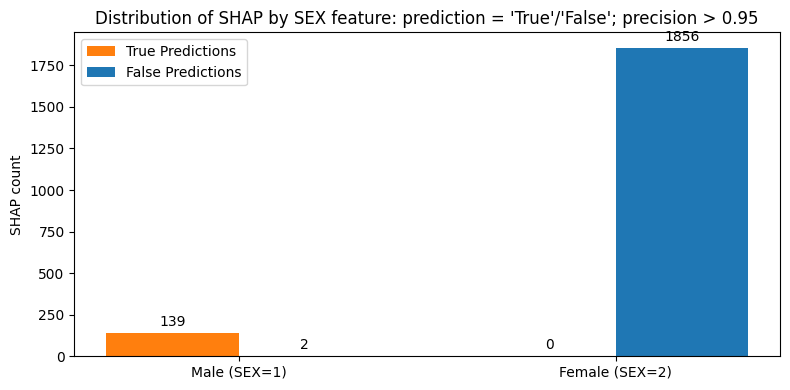

In [74]:
file = 'xai/output/json/skrub_tx_shap_explanations.json'
analyse_shap(file, 'num')

Total of test data:  13593
Total of shap of men:  3141
Total of shap of women:  4829
For true predictions: {1: 3134, 2: 1} 
For false predictions: {2: 4828, 1: 7}


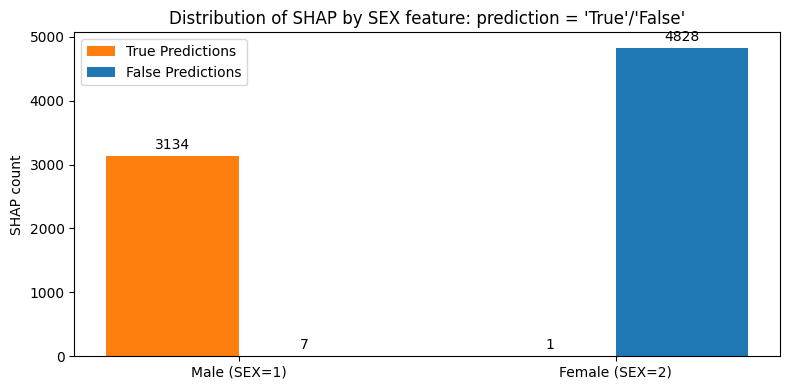

For true predictions and precision > 0.95: {1: 421, 2: 1} 
For false predictions and precision > 0.95: {2: 2323, 1: 4}


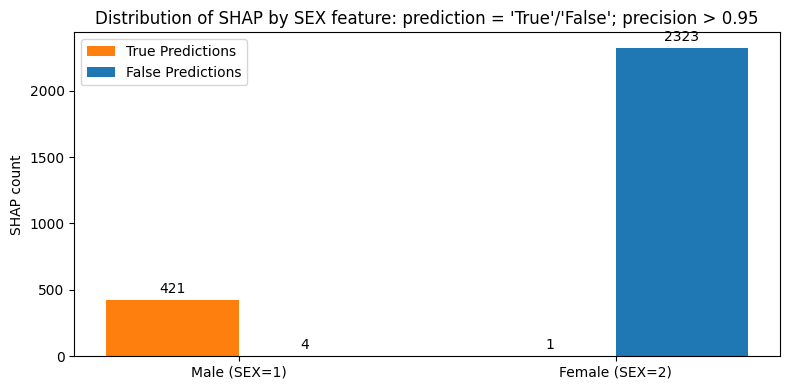

In [75]:
file = 'xai/output/json/xg_tx_shap_explanations.json'
analyse_shap(file, 'num')

Total of test data:  19567
Total of shap of men:  4938
Total of shap of women:  6132
For true predictions: {1: 4936} 
For false predictions: {2: 6132, 1: 2}


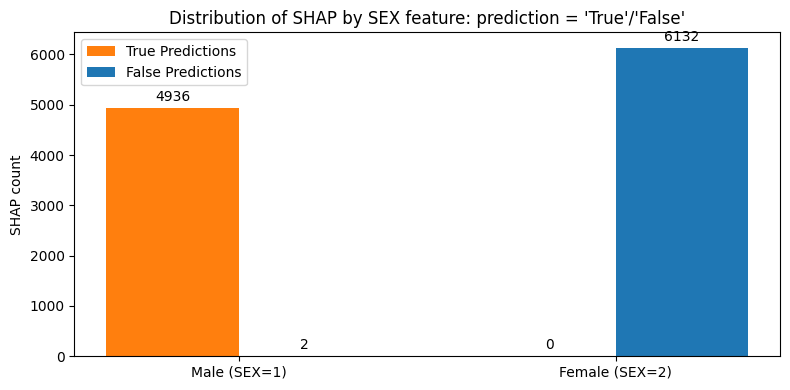

For true predictions and precision > 0.95: {1: 408} 
For false predictions and precision > 0.95: {2: 2357, 1: 2}


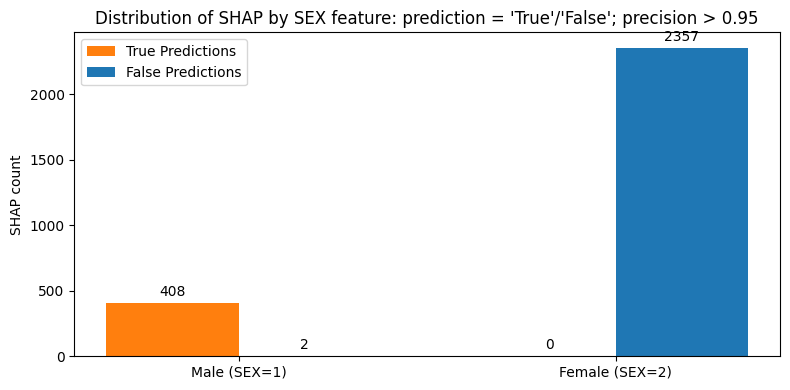

In [76]:
file = 'xai/output/json/skrub_ca_shap_explanations.json'
analyse_shap(file, 'num')

Total of test data:  19567
Total of shap of men:  4871
Total of shap of women:  6123
For true predictions: {1: 4852, 2: 3} 
For false predictions: {2: 6120, 1: 19}


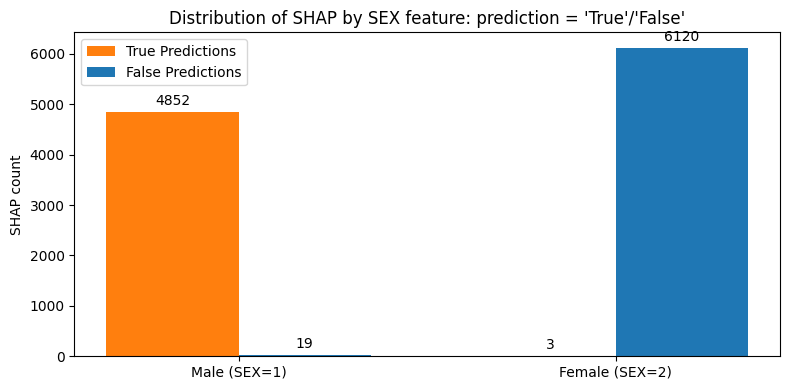

For true predictions and precision > 0.95: {1: 1016} 
For false predictions and precision > 0.95: {2: 2841, 1: 9}


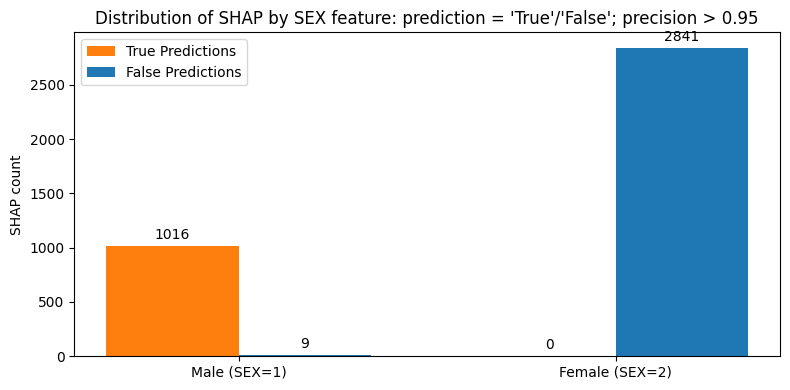

In [77]:
file = 'xai/output/json/xg_ca_shap_explanations.json'
analyse_shap(file, 'num')

Total of test data:  10303
Total of shap of men:  2465
Total of shap of women:  3273
For true predictions: {1: 2465} 
For false predictions: {2: 3273}


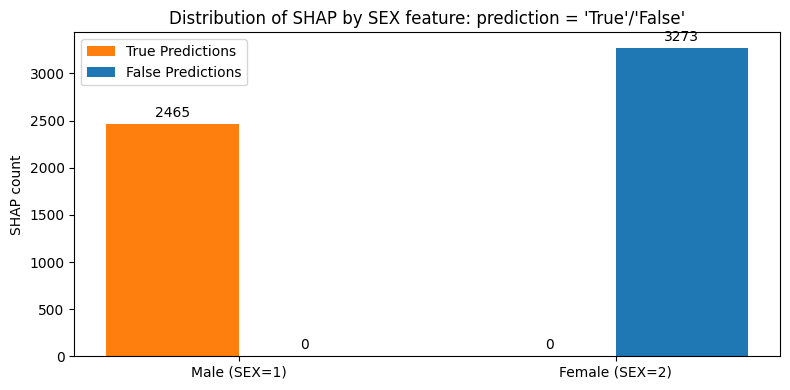

For true predictions and precision > 0.95: {1: 96} 
For false predictions and precision > 0.95: {2: 1062}


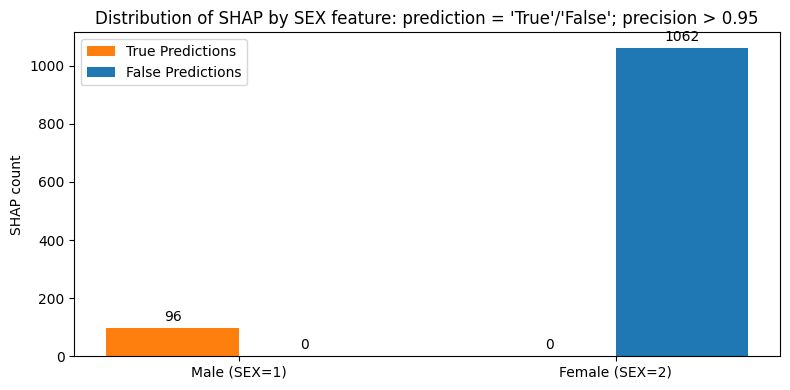

In [78]:
file = 'xai/output/json/skrub_ny_shap_explanations.json'
analyse_shap(file, 'num')

Total of test data:  10303
Total of shap of men:  2570
Total of shap of women:  3241
For true predictions: {1: 2562, 2: 4} 
For false predictions: {2: 3237, 1: 8}


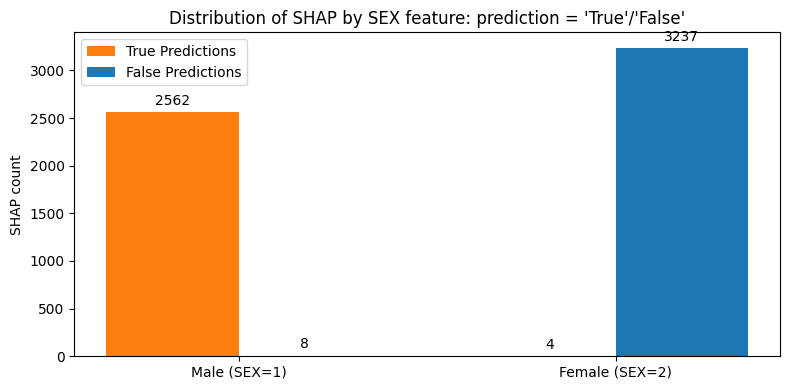

For true predictions and precision > 0.95: {1: 380, 2: 1} 
For false predictions and precision > 0.95: {2: 1311, 1: 2}


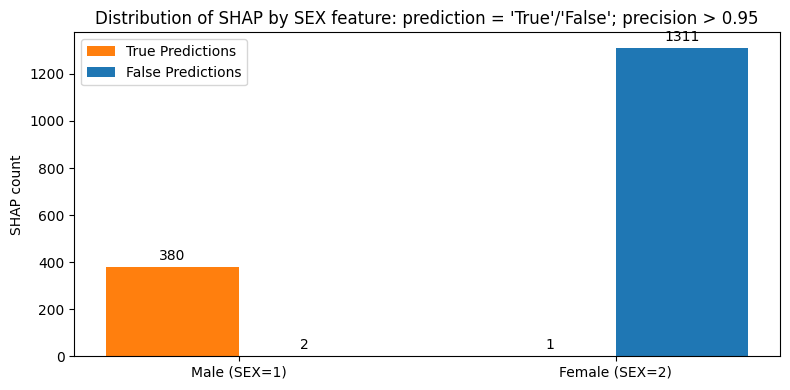

In [79]:
file = 'xai/output/json/xg_ny_shap_explanations.json'
analyse_shap(file, 'num')

In [80]:
with open(file, 'r', encoding='utf-8') as f:
    df = pd.read_json(f)
df = df.T
df.shape

(10303, 4)

KeyError: 'coverage'

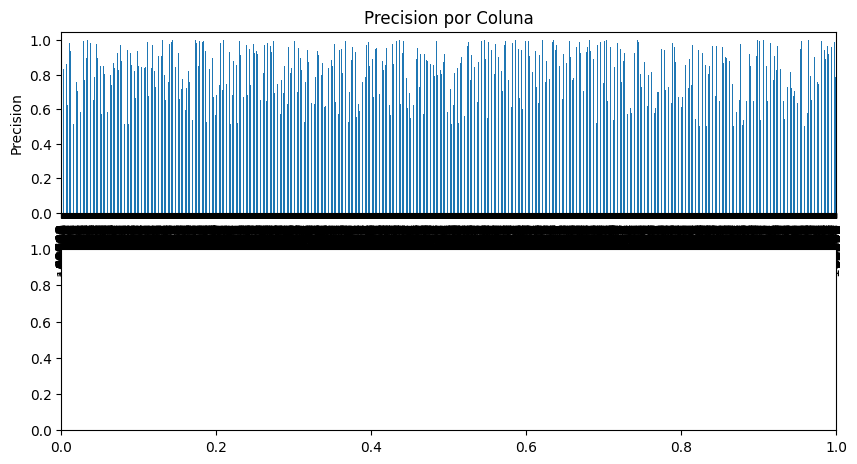

In [81]:
# Plotando precision e coverage
plt.figure(figsize=(10, 8))

# Plot para precision
plt.subplot(3, 1, 1)
df['precision'].plot(kind='bar', title='Precision por Coluna')
plt.ylabel('Precision')

# Plot para coverage
plt.subplot(3, 1, 2)
df['coverage'].plot(kind='bar', title='Coverage por Coluna')
plt.ylabel('Coverage')

# Plot para coverage
plt.subplot(3, 1, 3)
df['features'].apply(len).plot(kind='bar', title='Número de Features por Coluna')  # Calcula o tamanho de cada lista
plt.ylabel('Num features')

plt.tight_layout()
plt.show()

In [ ]:
def filtrar_metricas(df, min_precision=0.8, min_coverage=0.3, top_n=100):
    """
    Filtra o DataFrame por precision e coverage, convertendo tipos se necessário.
    
    Args:
        df: DataFrame a ser filtrado
        min_precision: valor mínimo de precision
        min_coverage: valor mínimo de coverage
        top_n: número de top resultados para retornar
        
    Returns:
        Tuple: (df_filtrado, top_precision, top_coverage)
    """
    try:
        # Verificar e converter tipos
        if df['precision'].dtype == 'object':
            df['precision'] = pd.to_numeric(df['precision'], errors='coerce')
        if df['coverage'].dtype == 'object':
            df['coverage'] = pd.to_numeric(df['coverage'], errors='coerce')
        
        # Remover valores inválidos
        df = df.dropna(subset=['precision', 'coverage'])
        
        # Aplicar filtros
        mask = (df['precision'] >= min_precision) & (df['coverage'] >= min_coverage)
        df_filtrado = df[mask].copy()
        
        # Obter tops
        top_precision = df.nlargest(top_n, 'precision')
        top_coverage = df.nlargest(top_n, 'coverage')
        
        return df_filtrado, top_precision, top_coverage
        
    except Exception as e:
        print(f"Erro ao filtrar: {str(e)}")
        return None, None, None


df_filtrado, top_prec, top_cov = filtrar_metricas(df)

In [ ]:
df_filtrado

In [ ]:
for i in df_filtrado['features']:
    print(i)
    #print(df_filtrado[i])